## Visualise the price movements of the different regimes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/var/folders/7r/gmcfwl7x7f35wnm9l7114rtw0000gn/T/ipykernel_91923/2151744951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
data = pd.read_csv('../data/backtest_data_with_technical_indicators.csv')
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index)

,regime,Volume,Open,High,Low,Close,ema_20,stddev_20,upper_band_1sd,lower_band_1sd,...,lower_band_2sd,fib_level_0.236,fib_level_0.382,fib_level_0.618,short_ema,long_ema,MACD_line,signal_line,MACD_histogram,RSI
Date,,,,,,,,,,,,,,,,,,,,,
1979-12-26,blue,24960000,107.78,107.78,107.78,107.78,107.780000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,107.780000,107.780000,0.000000,0.000000,0.000000,NaN
1979-12-27,blue,31410000,107.96,107.96,107.96,107.96,107.797143,0.127279,107.924422,107.669864,...,107.542584,NaN,NaN,NaN,107.807692,107.793333,0.014359,0.002872,0.011487,NaN
1979-12-28,blue,34430000,107.84,107.84,107.84,107.84,107.801224,0.092545,107.893770,107.708679,...,107.616134,NaN,NaN,NaN,107.812663,107.796790,0.015873,0.005472,0.010401,NaN
1979-12-31,blue,31530000,107.94,107.94,107.94,107.94,107.814441,0.097630,107.912072,107.716811,...,107.619180,NaN,NaN,NaN,107.832253,107.807398,0.024855,0.009349,0.015506,NaN
1980-01-02,blue,40610000,105.76,105.76,105.76,105.76,107.618780,0.837794,108.456574,106.780986,...,105.943192,NaN,NaN,NaN,107.513445,107.655739,-0.142294,-0.020980,-0.121314,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,blue,4748110000,5098.51,5140.33,5094.16,5137.08,5020.372353,99.135149,5119.507501,4921.237204,...,4822.102055,4826.10308,4631.70846,4317.48154,5057.907372,4993.257677,64.649695,62.203764,2.445931,70.387006
2024-03-04,blue,4758440000,5130.99,5149.67,5127.18,5130.95,5030.903557,100.004308,5130.907865,4930.899249,...,4830.894942,4833.23884,4637.48058,4321.04942,5069.144699,5003.457108,65.687591,62.900530,2.787061,69.220177
2024-03-05,blue,4418410000,5110.52,5114.54,5056.82,5078.65,5035.450837,96.203826,5131.654663,4939.247011,...,4843.043186,4833.23884,4637.48058,4321.04942,5070.607053,5009.026952,61.580101,62.636444,-1.056343,60.070573


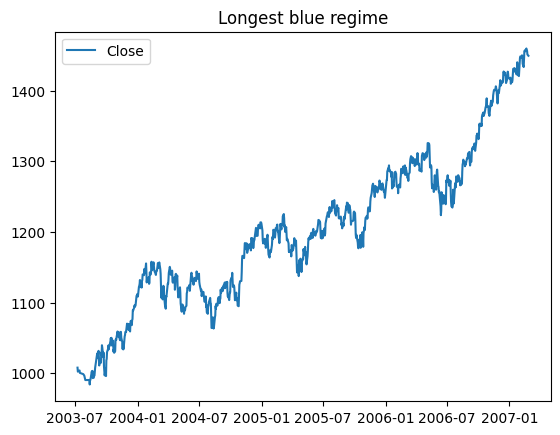

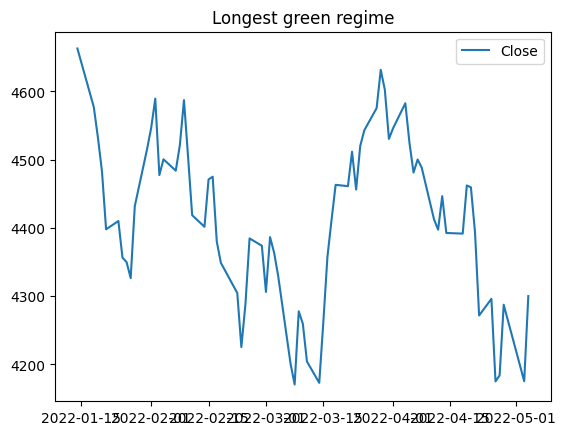

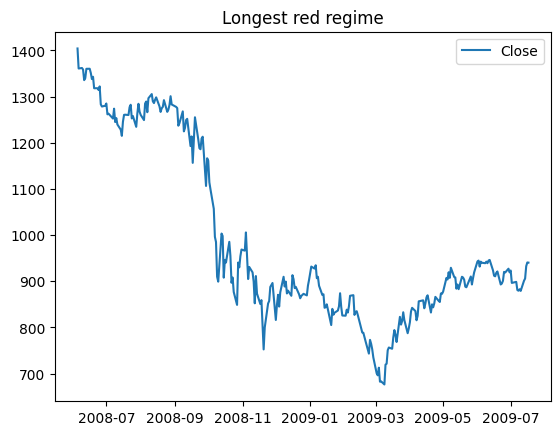

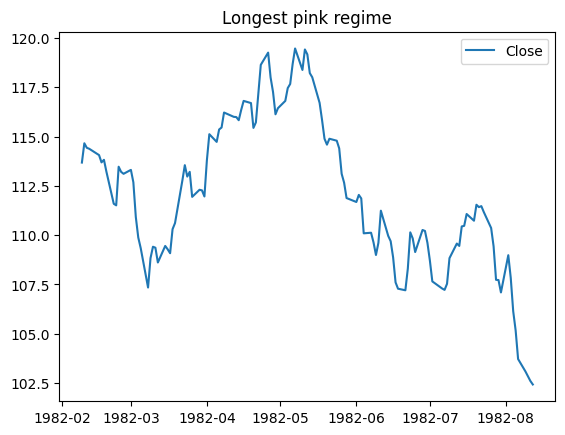

In [33]:
# Define the regimes
regimes = data['regime'].unique()

# Create a dictionary to store the dataframes
regime_dfs = {}

# Iterate over each regime
for regime in regimes:
    # Create a boolean series where True indicates a change in regime or a change from the current regime
    data['regime_change'] = (data['regime'].shift() != data['regime']) | (data['regime'] != regime)

    # Create a series that groups the data into continuous regimes
    data['regime_group'] = data['regime_change'].cumsum()

    # Count the number of rows in each group
    group_counts = data.groupby('regime_group').size()

    # Find the group with the maximum count
    max_group = group_counts.idxmax()

    # Filter the data for the longest continuous regime
    longest_regime = data[(data['regime_group'] == max_group) & (data['regime'] == regime)]

    # Drop the helper columns
    longest_regime = longest_regime.drop(columns=['regime_change', 'regime_group'])

    # Store the dataframe in the dictionary
    regime_dfs[regime] = longest_regime
    

# Iterate over each regime
for regime, df in regime_dfs.items():
    # Create a new figure
    plt.figure()

    # Plot the 'Close' column
    plt.plot(df['Close'], label='Close')

    # Set the title
    plt.title(f'Longest {regime} regime')

    # Show the legend
    plt.legend()

# Show the plots
plt.show()

## Advance

Follow up trend  
Go long on pullbacks and breakouts  

LONG Bullish low var - Lower band crossover 1SD, , Lower band crossover 1.5SD, Lower band crossover 2SD, Upper band crossover 2SD  
LONG Bullish low var -  Fib 0.382, Fib 0.5, 0.236  
LONG Bullihs low var - All, especially RSI 30 and 40  

FINAL STRAT

LONG: Lower band crossover 1.5SD  
Fib 0.382  
RSI 30  

EXIT: Upper band crossover 1.5SD  
fib 0.618  
RSI 70
Price cross below 10 day EMA  
Take profit EMA + 3*ATR  
Stop Loss EMA - 3*ATR

## Accumulation

Long lows of the range  
Stop loss above support, Take profit Swing High

## Decline

Follow down trend  
Go short on pullbacks and breakouts

## Distribution

Short highs of the range  
Stop loss above resistance, take profits Swing low